# CottonWeed15 - MobileNetV3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-06-01 05:53:05.486489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 05:53:05.486613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 05:53:05.600457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running Deterministically


In [2]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

,img,label
0,351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg,Nutsedge
1,992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg,Nutsedge
2,8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg,Nutsedge
3,e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg,Nutsedge
4,IMG_0547.JPG,Nutsedge
...,...,...
5182,1f101adc29984ee783d36d96ad6e5b7d__purselane__2...,Purslane
5183,0001.jpg,Purslane
5184,IMG_1426.JPG,Purslane
5185,IMG_1481 (3).JPG,Purslane


In [5]:
label_counts = data_info.groupby('label').count()
label_counts.T

label,Carpetweeds,Crabgrass,Eclipta,Goosegrass,Morningglory,Nutsedge,PalmerAmaranth,Prickly Sida,Purslane,Ragweed,Sicklepod,SpottedSpurge,SpurredAnoda,Swinecress,Waterhemp
img,763,111,254,216,1115,273,689,129,450,129,240,234,61,72,451


In [6]:
# label2id = data_info['label'].unique()
# label2id = {label2id[i]:i for i in range(len(label2id))}
# id2label = {label2id[i]:i for i in label2id}
label2id = {'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3,
            'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7,
            'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11,
            'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
id2label = {label2id[i]:i for i in label2id}
class_names = [id2label[i] for i in range(len(label2id))]

print(id2label)
print(label2id)
print(class_names)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']


In [7]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)
data_info['id'] = data_info.apply(lambda x: label2id[x['label']], axis=1)

In [8]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 1 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 2 out of 5 folds
-------------------------------------------------



In [10]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            610         89      204         172           892       218   
id             610         89      204         172           892       218   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               552           103       360      103        192   
id                552           103       360      103        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              188            48          58        360  
id               188            48          58        360   	Total: (4149, 3)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            153         22       50          44           223        55   
id             153         22       50          44           223        55   

label  PalmerAmarant

# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [13]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
train_generator, validation_generator = getDatasetGenerators(
      train_dir,
      batch_size=12,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.25,
      subset="both"
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=12,
      shuffle=True,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
)

Found 4149 files belonging to 15 classes.
Using 3112 files for training.
Using 1037 files for validation.
Found 1038 files belonging to 15 classes.


In [15]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

# Sample Images

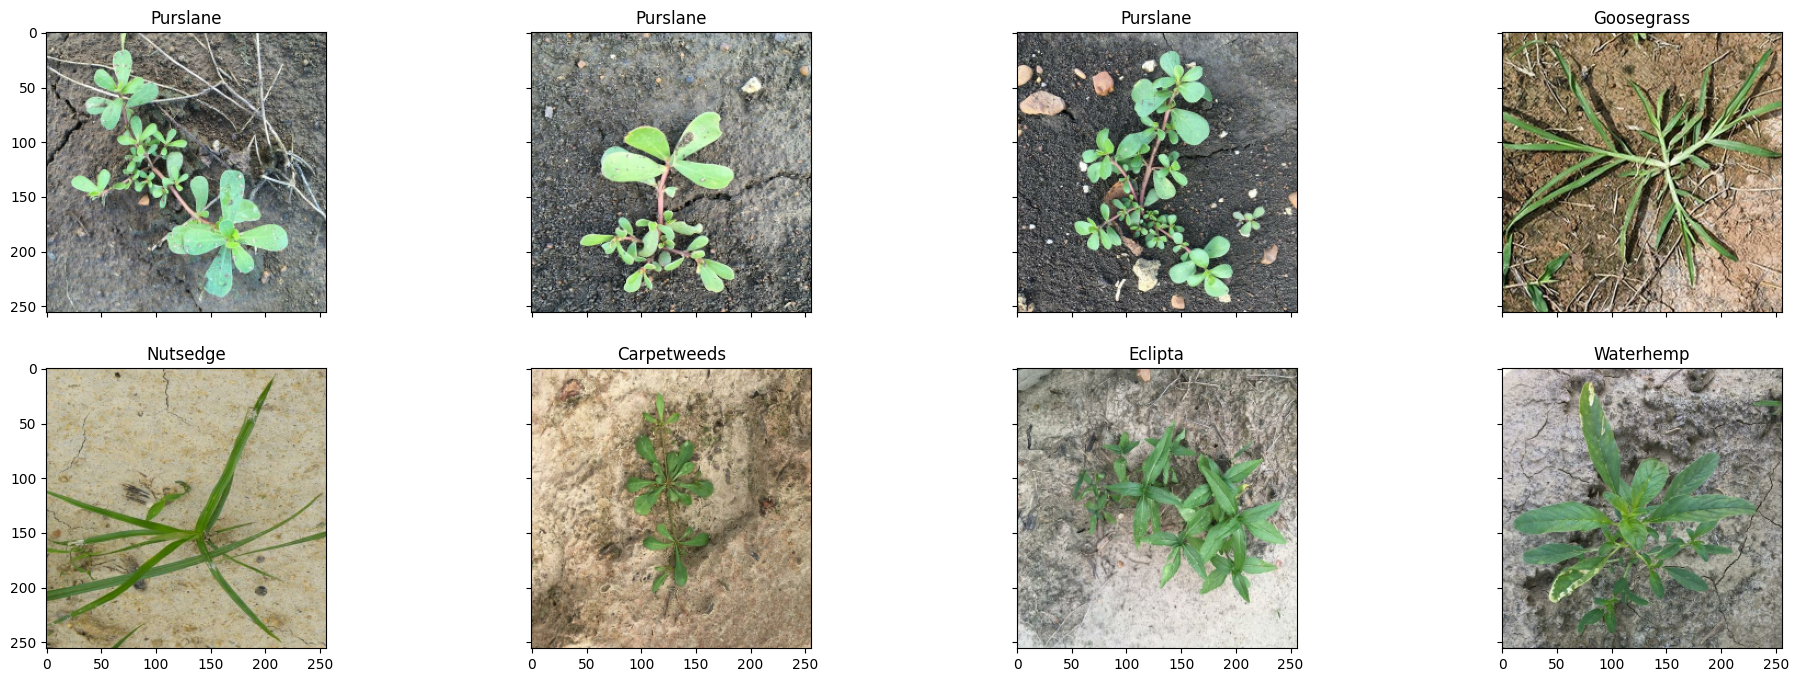

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [18]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [19]:
def spatial_attention(input_feature):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [20]:
def MultiFilterSpatialAttention(input_feature, kernel_size=7, num_pooled_channel=4, layer_num = 0):
    in_shape = input_feature.shape

    pool_size =  in_shape[-1] // num_pooled_channel

    channel_avg = SpatialAveragePooling2D(pool_size, padding='same', name='MFSA_SAP_L{}'.format(layer_num))(input_feature)
    channel_max = SpatialMaxPooling2D(pool_size, padding='same' , name='MFSA_SMP_L{}'.format(layer_num))(input_feature)

    concat = layers.Concatenate(axis=3, name='MFSA_ConcatChannels_L{}'.format(layer_num))([channel_avg, channel_max])

    sa_feature_x = layers.Conv2D(filters = in_shape[-1],
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    groups= num_pooled_channel,
                    use_bias=False,
                    name="MFSA_Conv_L{}".format(layer_num))(concat)

    # sa_shape = sa_feature_x.shape

    sa_feature_x =  layers.multiply([input_feature, sa_feature_x])

    # sa_feature_x = Reshape((in_shape[1], in_shape[2], -1), name="MFSA_OutBackwardReshape_L{}".format(layer_num))(sa_feature_x)
    return sa_feature_x

# Building MobileNet Model

In [21]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)
    
    x = spatial_attention(x)
    x = layers.Dense(x.shape[-1]//4, activation='relu', name='feature_poolerf1')(x)
    x = layers.Dense(x.shape[-1] * 4, activation='gelu', name='feature_poolerf2')(x)


    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [22]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 PP_Rescale (Rescaling)      (None, 256, 256, 3)          0         ['input[0][0]']               
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale[0][0]']          
                                                                                                  
 augment_pipeline (Sequenti  (None, 224, 224, 3)          0

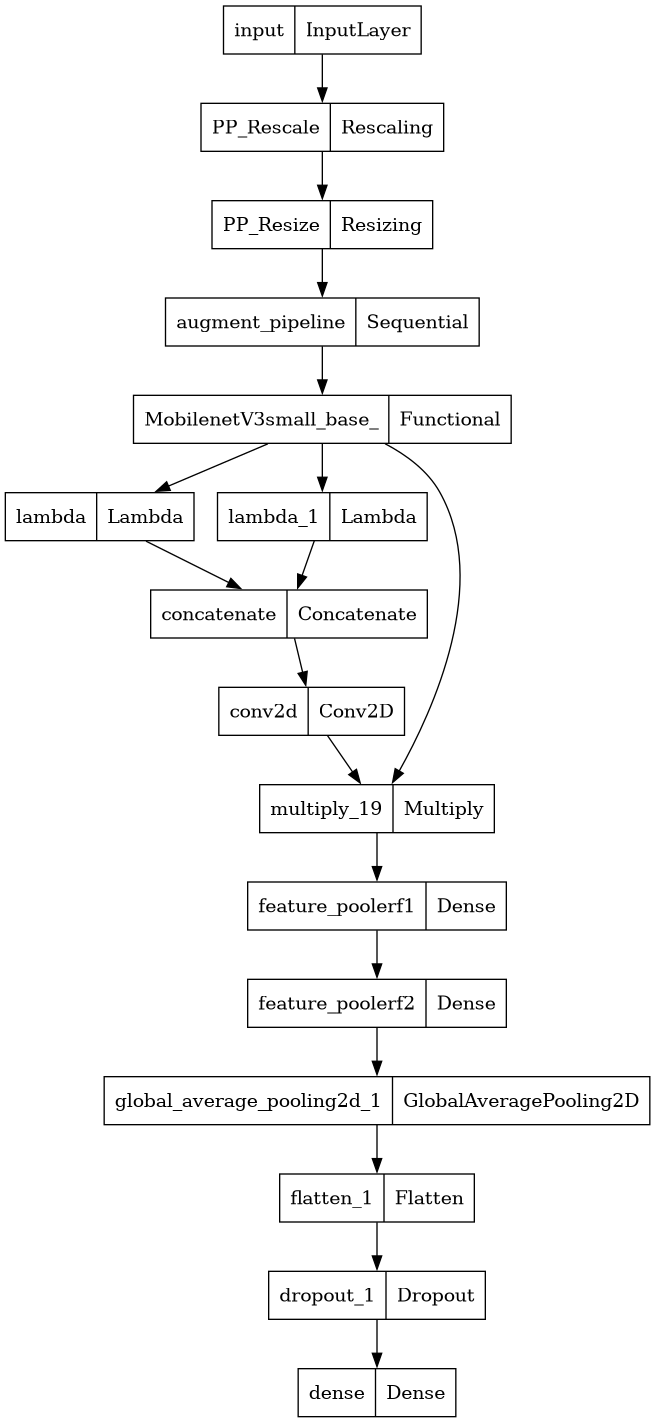

In [23]:
keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [24]:
from tensorflow.keras.optimizers import Adam, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 15
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/100


I0000 00:00:1717221255.197877      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 45s 56ms/step - loss: 2.3511 - accuracy: 0.2237 - val_loss: 2.0596 - val_accuracy: 0.3308 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 13s 51ms/step - loss: 1.8632 - accuracy: 0.4001 - val_loss: 1.4924 - val_accuracy: 0.5275 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 14s 52ms/step - loss: 1.4175 - accuracy: 0.5559 - val_loss: 1.0511 - val_accuracy: 0.6692 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - 14s 52ms/step - loss: 1.1089 - accuracy: 0.6459 - val_loss: 0.7944 - val_accuracy: 0.7493 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 13s 50ms/step - loss: 0.9032 - accuracy: 0.7063 - val_loss: 0.7116 - val_accuracy: 0.7753 - lr: 2.0000e-04
Epoch 6/100
260/260 [==============================] - 13s 49ms/step - loss: 0.7814 - accuracy: 0.7503 - val_loss: 0.6013 - val_accuracy: 0.8091 - lr: 2.0000e-04
Epoch 7/100
260/260 [===================

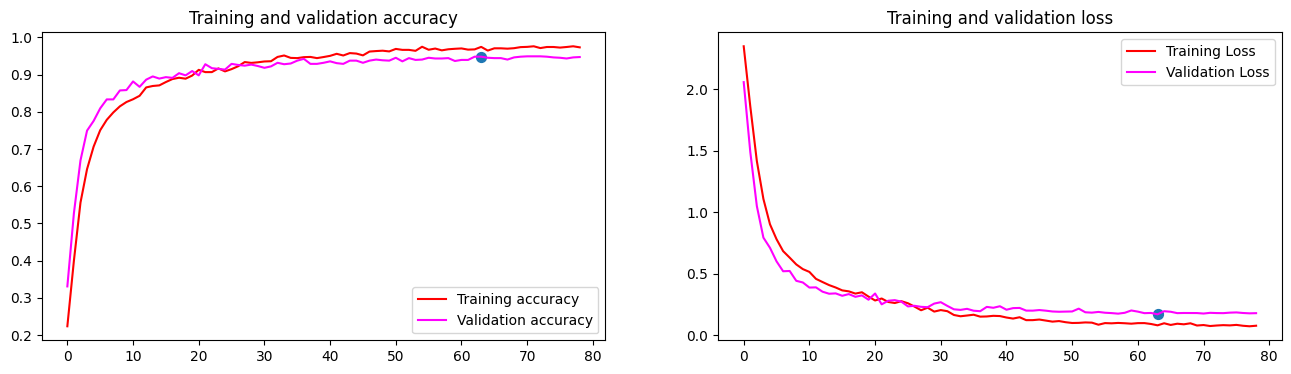

CPU times: user 34min 36s, sys: 1min 41s, total: 36min 18s
Wall time: 17min 49s


In [25]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.1706 - accuracy: 0.9479
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.97872   0.95833   0.96842        48
     Sicklepod    0.95652   0.95652   0.95652        46
  Morningglory    0.93991   0.98206   0.96053       223
       Ragweed    0.95455   0.95455   0.95455        22
PalmerAmaranth    0.94366   0.94366   0.94366       142
     Waterhemp    0.94118   0.98765   0.96386        81
     Crabgrass    1.00000   1.00000   1.00000        21
    Swinecress    1.00000   0.84615   0.91667        13
  Prickly Sida    0.90000   0.66667   0.76596        27
   Carpetweeds    0.96178   0.96795   0.96486       156
 SpottedSpurge    0.92157   0.95918   0.94000        49
  SpurredAnoda    0.75000   0.54545   0.63158        11
       Eclipta    0.98039   0.87719   0.92593        57
    Goosegrass    0.93182   0.97619   0.95349        42
      Purslane    0.94949   0.94949   0.94949        99

      accuracy                        0.94793      1037
     macro avg    0.94064 

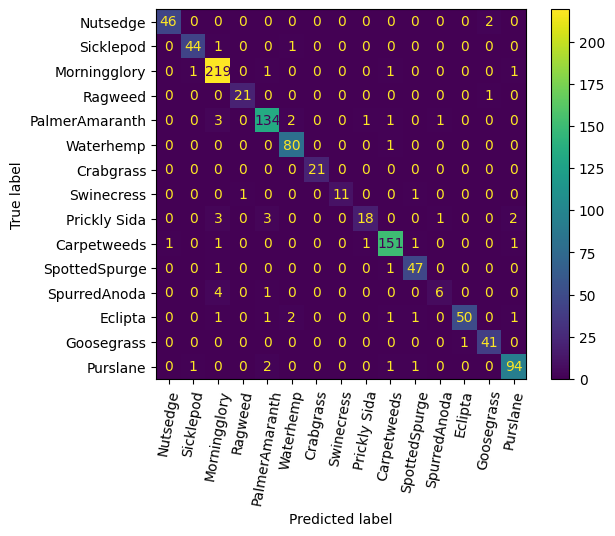

In [26]:
a, b = eval_model(model, validation_generator)

model.evaluate
87/87 [==============================] - 1s 15ms/step - loss: 0.1341 - accuracy: 0.9538
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.96429   0.98182   0.97297        55
     Sicklepod    0.95918   0.97917   0.96907        48
  Morningglory    0.96460   0.97758   0.97105       223
       Ragweed    1.00000   0.92308   0.96000        26
PalmerAmaranth    0.94286   0.96350   0.95307       137
     Waterhemp    0.94382   0.92308   0.93333        91
     Crabgrass    0.88000   1.00000   0.93617        22
    Swinecress    0.93333   1.00000   0.96552        14
  Prickly Sida    0.83333   0.76923   0.80000        26
   Carpetweeds    0.97368   0.96732   0.97049       153
 SpottedSpurge    0.97778   0.95652   0.96703        46
  SpurredAnoda    0.92308   0.92308   0.92308        13
       Eclipta    0.91837   0.90000   0.90909        50
    Goosegrass    0.97561   0.90909   0.94118        44
      Purslane    0.96667   0.96667   0.96667        90

      accuracy                        0.95472      1038
     macro avg    0.94377 

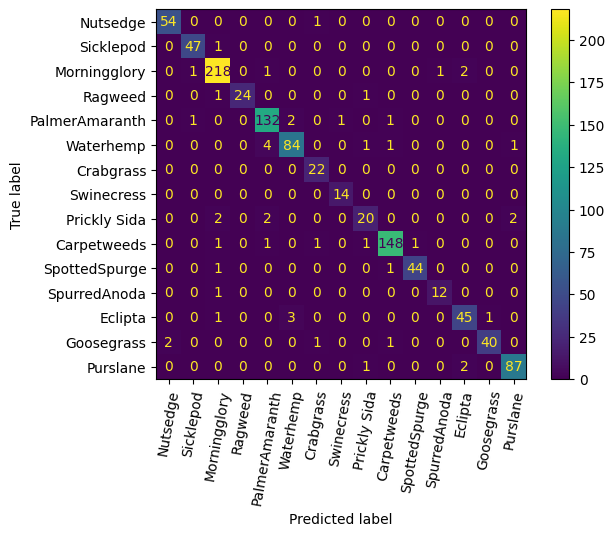

In [27]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/100
260/260 [==============================] - 12s 27ms/step - loss: 0.4693 - accuracy: 0.8483 - val_loss: 0.3128 - val_accuracy: 0.9016 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 6s 22ms/step - loss: 0.3209 - accuracy: 0.8956 - val_loss: 0.2976 - val_accuracy: 0.9113 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 6s 24ms/step - loss: 0.3266 - accuracy: 0.8991 - val_loss: 0.2832 - val_accuracy: 0.9132 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - 6s 22ms/step - loss: 0.2935 - accuracy: 0.9052 - val_loss: 0.2542 - val_accuracy: 0.9132 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 6s 23ms/step - loss: 0.2789 - accuracy: 0.9103 - val_loss: 0.2544 - val_accuracy: 0.9248 - lr: 2.0000e-04
Epoch 6/100
260/260 [==============================] - 6s 22ms/step - loss: 0.2614 - accuracy: 0.9171 - val_loss: 0.2917 - val_accuracy: 0.9103 - lr: 2.0000

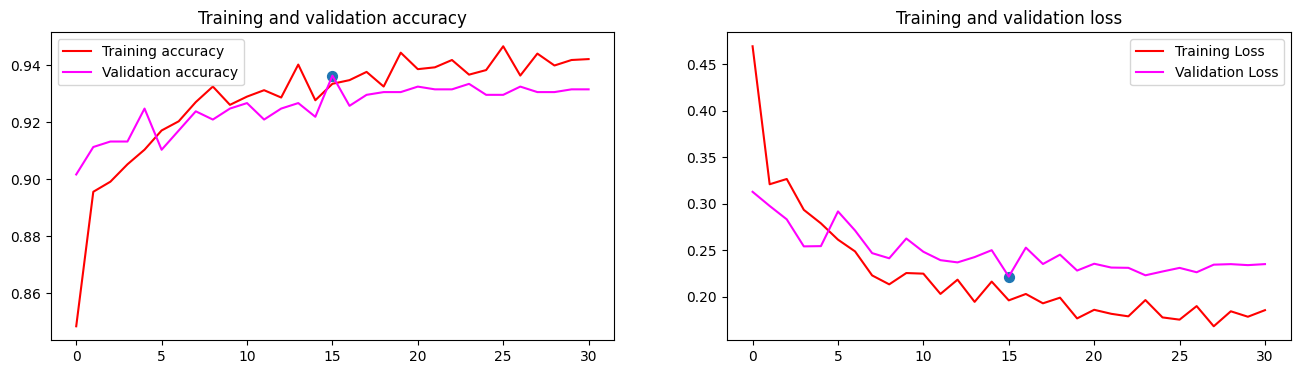

CPU times: user 9min 31s, sys: 29.7 s, total: 10min 1s
Wall time: 3min 22s


In [28]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
    optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
    metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Evaluations

Total Epochs: range(0, 110)


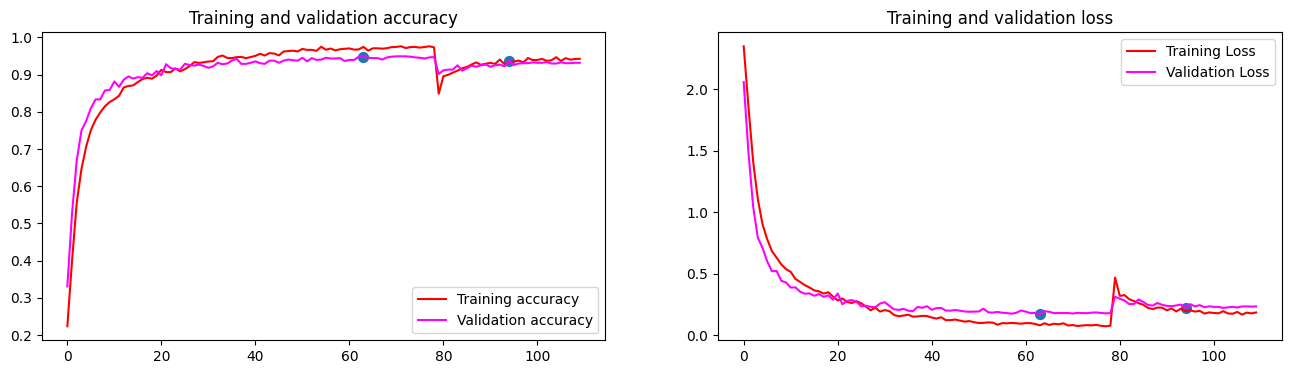

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 79)


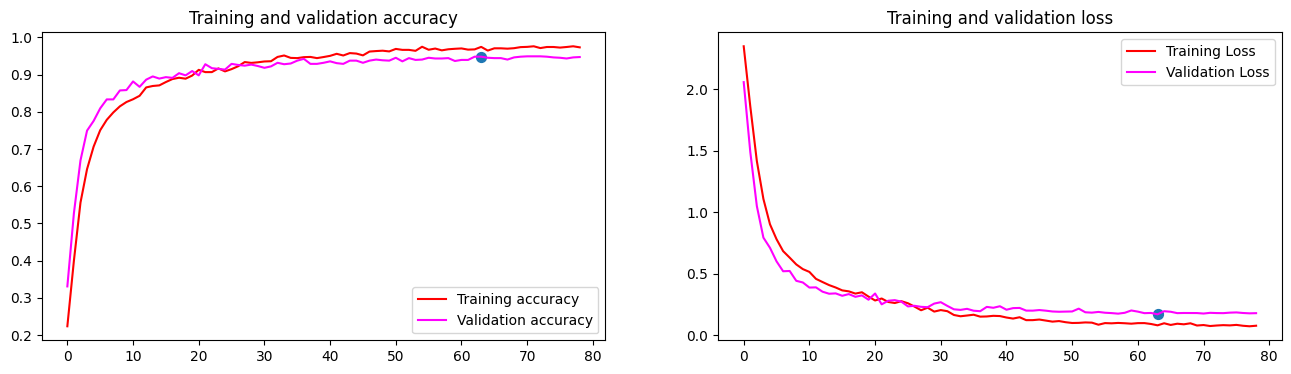

Total Epochs: range(0, 31)


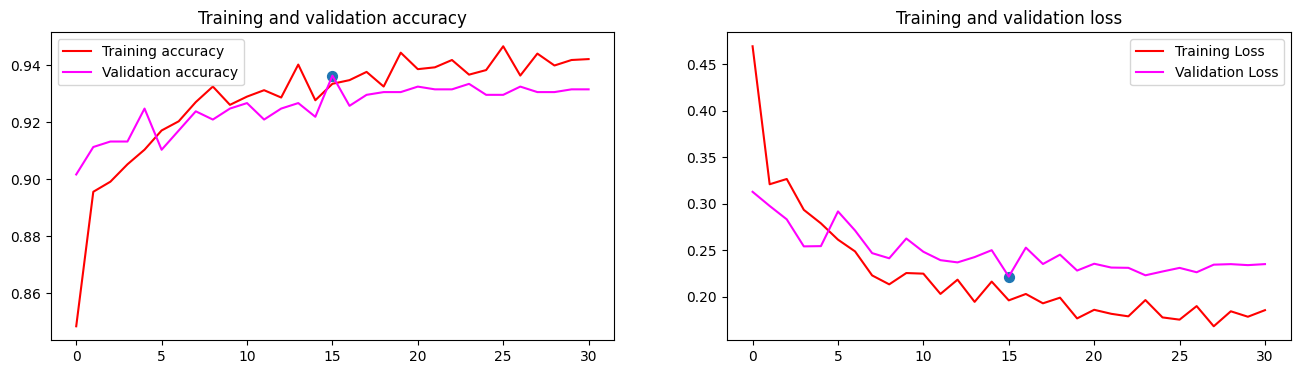

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.2217 - accuracy: 0.9364
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.94118   1.00000   0.96970        48
     Sicklepod    0.78947   0.97826   0.87379        46
  Morningglory    0.97696   0.95067   0.96364       223
       Ragweed    0.91304   0.95455   0.93333        22
PalmerAmaranth    0.92517   0.95775   0.94118       142
     Waterhemp    0.92683   0.93827   0.93252        81
     Crabgrass    1.00000   1.00000   1.00000        21
    Swinecress    1.00000   0.84615   0.91667        13
  Prickly Sida    0.75000   0.66667   0.70588        27
   Carpetweeds    0.92638   0.96795   0.94671       156
 SpottedSpurge    1.00000   0.79592   0.88636        49
  SpurredAnoda    0.72727   0.72727   0.72727        11
       Eclipta    0.92982   0.92982   0.92982        57
    Goosegrass    1.00000   0.97619   0.98795        42
      Purslane    0.97849   0.91919   0.94792        99

      accuracy                        0.93635      1037
     macro avg    0.91897 

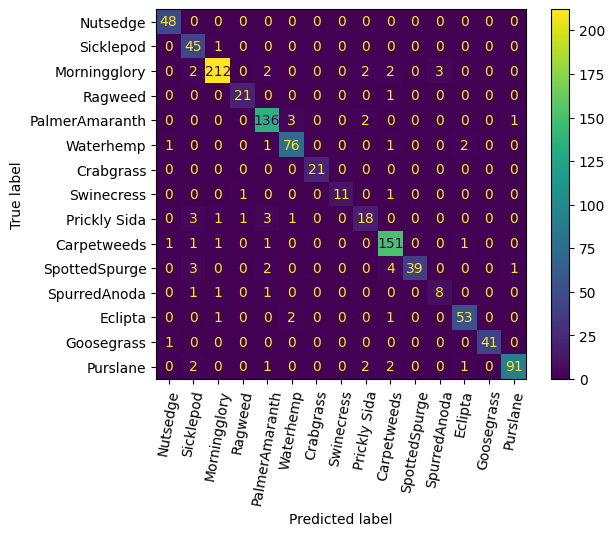

In [31]:

a, b = eval_model(model,validation_generator)

# Test Set Evaluation

model.evaluate
87/87 [==============================] - 1s 13ms/step - loss: 0.2170 - accuracy: 0.9393
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.96364   0.96364   0.96364        55
     Sicklepod    0.81356   1.00000   0.89720        48
  Morningglory    0.99034   0.91928   0.95349       223
       Ragweed    0.96296   1.00000   0.98113        26
PalmerAmaranth    0.95652   0.96350   0.96000       137
     Waterhemp    0.94382   0.92308   0.93333        91
     Crabgrass    0.87500   0.95455   0.91304        22
    Swinecress    1.00000   1.00000   1.00000        14
  Prickly Sida    0.86667   1.00000   0.92857        26
   Carpetweeds    0.94268   0.96732   0.95484       153
 SpottedSpurge    1.00000   0.86957   0.93023        46
  SpurredAnoda    0.61111   0.84615   0.70968        13
       Eclipta    0.88235   0.90000   0.89109        50
    Goosegrass    0.93182   0.93182   0.93182        44
      Purslane    0.95294   0.90000   0.92571        90

      accuracy                        0.93931      1038
     macro avg    0.91289 

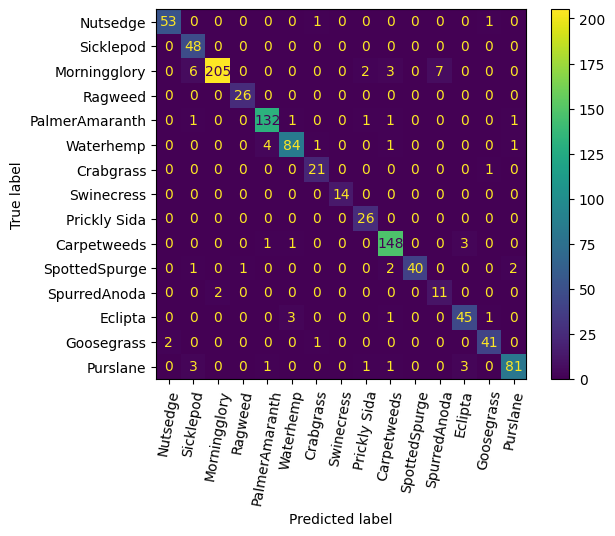

In [32]:
a, b = eval_model(model, test_generator)

In [33]:
shutil.rmtree(base_dir)